### Project: Sentiment Analysis using Scikit-learn Pipelines and Flask Deployment
### Developer: Sahil Kayastha
### Goal: Clean NLP pipeline using TfidfVectorizer, Logistic RegressionCV, evaluation, and Pickle export.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
train_df = pd.read_csv("Train.csv")
valid_df = pd.read_csv("Valid.csv")
test_df = pd.read_csv("Test.csv")

In [3]:
train_df.head()

text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1

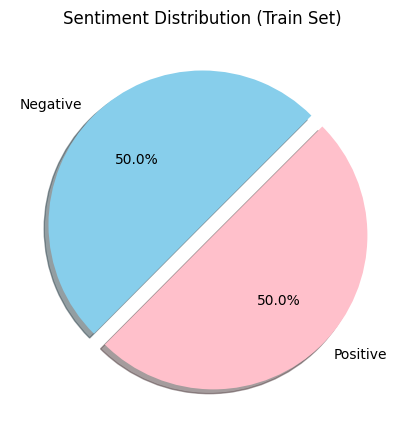

In [4]:
plt.figure(figsize=(5, 5))
train_df['label'].value_counts().plot.pie(
    labels=["Negative", "Positive"],
    autopct='%1.1f%%',
    colors=["skyblue", "pink"],
    shadow=True,
    startangle=45,
    explode=(0, 0.1)
)

plt.title("Sentiment Distribution (Train Set)")
plt.ylabel('')
plt.show()

In [5]:
import re
from sklearn.base import BaseEstimator, TransformerMixin

In [6]:
class TextCleaner(BaseEstimator, TransformerMixin):
    def remove_html(self, text):
        return re.sub('<[^>]*>', '', text)

    def remove_non_words(self, text):
        return re.sub('[\W]+', ' ', text.lower())

    def extract_emojis(self, text):
        emojis = re.findall(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
        return ' '.join(emojis).replace('-', '')

    def preprocess(self, text):
        text = self.remove_html(text)
        text = self.remove_non_words(text)
        emojis = self.extract_emojis(text)
        return text + ' ' + emojis

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.preprocess)

In [7]:
from wordcloud import WordCloud

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
from nltk.corpus import stopwords

In [10]:
stop = stopwords.words('english')

In [11]:
def plot_wordcloud(data, label, color='white'):
    text_data = ' '.join(data[data['label'] == label]['text'].tolist())
    cleaned_words = " ".join([word for word in text_data.split() if word not in ['movie', 'film']])
    wordcloud = WordCloud(
        stopwords=stop,
        background_color=color,
        width=2500,
        height=2000
    ).generate(cleaned_words)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    sentiment = "Positive" if label == 1 else "Negative"
    plt.title(f"Word Cloud for {sentiment} Sentiment")
    plt.show()

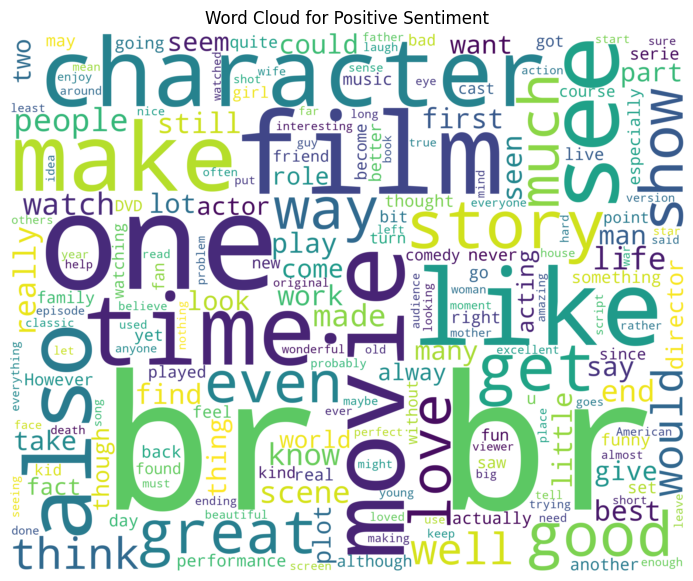

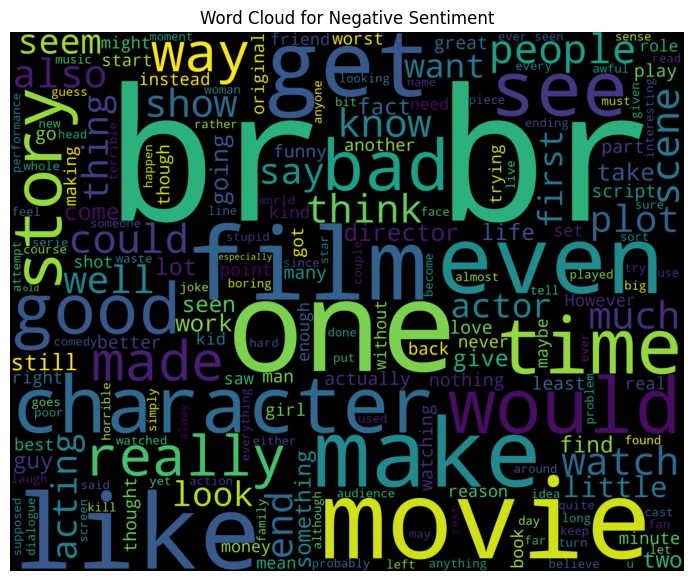

In [13]:
# Plot word clouds
plot_wordcloud(train_df, 1, 'white')
plot_wordcloud(train_df, 0, 'black')

In [14]:
from sklearn.pipeline import Pipeline

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

In [16]:
porter = PorterStemmer()

In [17]:
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split() if word not in stop]

In [19]:
from sklearn.linear_model import LogisticRegressionCV

In [20]:
pipeline = Pipeline([
    ('cleaner', TextCleaner()),
    ('vectorizer', TfidfVectorizer(tokenizer=tokenizer_porter, lowercase=False)),
    ('classifier', LogisticRegressionCV(cv=5, scoring='accuracy', max_iter=500, random_state=0, n_jobs=-1))
])

In [21]:
X_train = train_df['text']
y_train = train_df['label']

In [22]:
pipeline.fit(X_train, y_train)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('cleaner', TextCleaner()),
                ('vectorizer',
                 TfidfVectorizer(lowercase=False,
                                 tokenizer=<function tokenizer_porter at 0x000001730DDD1800>)),
                ('classifier',
                 LogisticRegressionCV(cv=5, max_iter=500, n_jobs=-1,
                                      random_state=0, scoring='accuracy'))])

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

In [24]:
X_valid = valid_df['text']
y_valid = valid_df['label']

In [25]:
y_val_pred = pipeline.predict(X_valid)

In [26]:
print("Validation Accuracy:", accuracy_score(y_valid, y_val_pred))
print(classification_report(y_valid, y_val_pred))

Validation Accuracy: 0.8954
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      2486
           1       0.89      0.91      0.90      2514

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



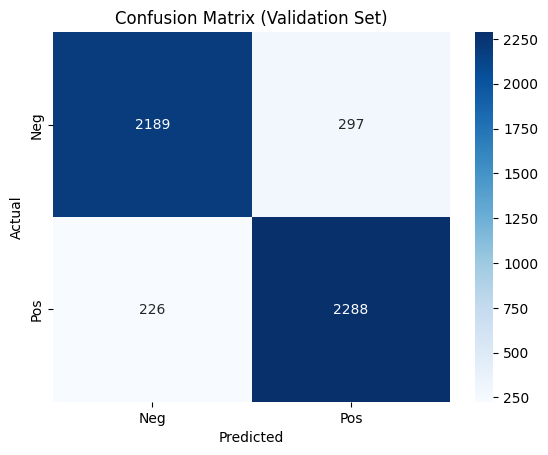

In [27]:
cm = confusion_matrix(y_valid, y_val_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

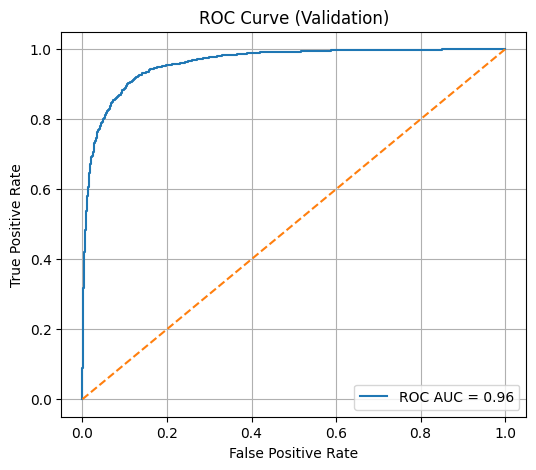

In [28]:
if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
    y_val_proba = pipeline.predict_proba(X_valid)[:, 1]
    fpr, tpr, _ = roc_curve(y_valid, y_val_proba)
    auc_score = roc_auc_score(y_valid, y_val_proba)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Validation)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


In [29]:
X_test = test_df['text']
y_test = test_df['label']
y_test_pred = pipeline.predict(X_test)

In [30]:
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.8972
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      2495
           1       0.89      0.91      0.90      2505

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



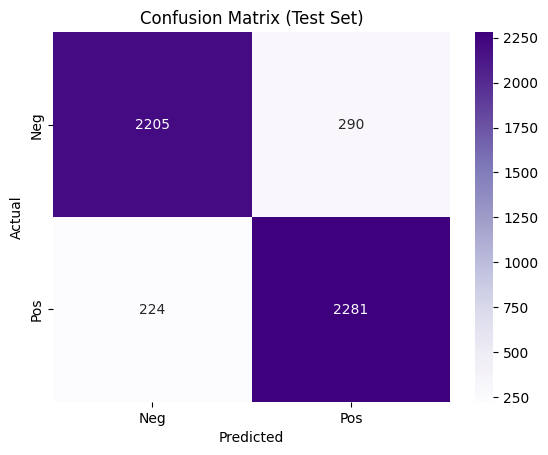

In [31]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [33]:
import pickle

In [34]:
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(pipeline, f)
print("Final model saved as 'sentiment_model.pkl'")

Final model saved as 'sentiment_model.pkl'
